In [107]:
import numpy as np

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

attention_pars = []

for subject in range(1, 15):
    try:
        pars = pd.read_csv(f'/data/ds-retsupp/derivatives/attention_model/sub-{subject:02d}/sub-{subject:02d}_desc-attentionmodel_summary.tsv', sep='\t')
        pars['subject'] = subject
        attention_pars.append(pars)
    except FileNotFoundError:
        print(f'No attention model parameters found for subject {subject}, skipping.')

pars = pd.concat(attention_pars)

pars.set_index(['subject', 'roi'], inplace=True)
pars

No attention model parameters found for subject 6, skipping.


fitted_attention_sd  fitted_ratio_log  fitted_ratio  final_error  \
subject roi                                                                     
1       LO1           100.000000         -2.471493      0.084459   431.649801   
        LO2           100.000000         -2.403183      0.090430   172.345333   
        TO1            61.468893         -1.899127      0.149699   377.974397   
        TO2            99.999990         -1.896764      0.150053   136.455711   
        V1             99.999998         -2.326984      0.097590   735.969237   
...                          ...               ...           ...          ...   
14      V3A            10.000000          1.772553      5.885861    27.724588   
        V3B            16.439571         -0.601147      0.548183   275.111934   
        VO1            10.000001          0.227963      1.256039    57.017709   
        VO2            10.000000          5.499999    244.691693     5.963561   
        hV4            10.000000          4.645919    104.159086   294.826263   

             optimization_success  
subject roi                        
1       LO1                  True  
        LO2                  True  
        TO1                  True  
        TO2                  True  
        V1                   True  
...                           ...  
14      V3A                  True  
        V3B                  True  
        VO1                  True  
        VO2                  True  
        hV4                  True  

[156 rows x 5 columns]

<Axes: xlabel='fitted_attention_sd', ylabel='Count'>

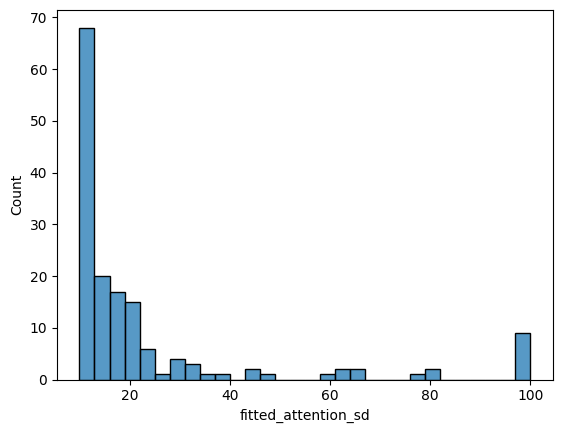

In [108]:
sns.histplot(np.clip(pars['fitted_attention_sd'], 0, 100), bins=30)

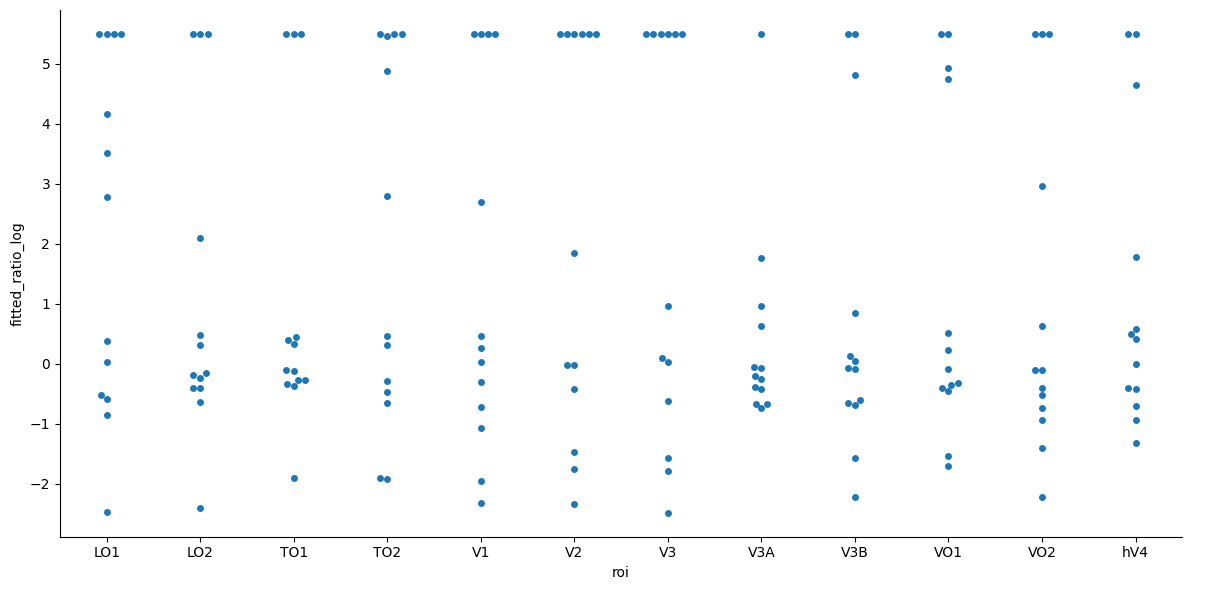

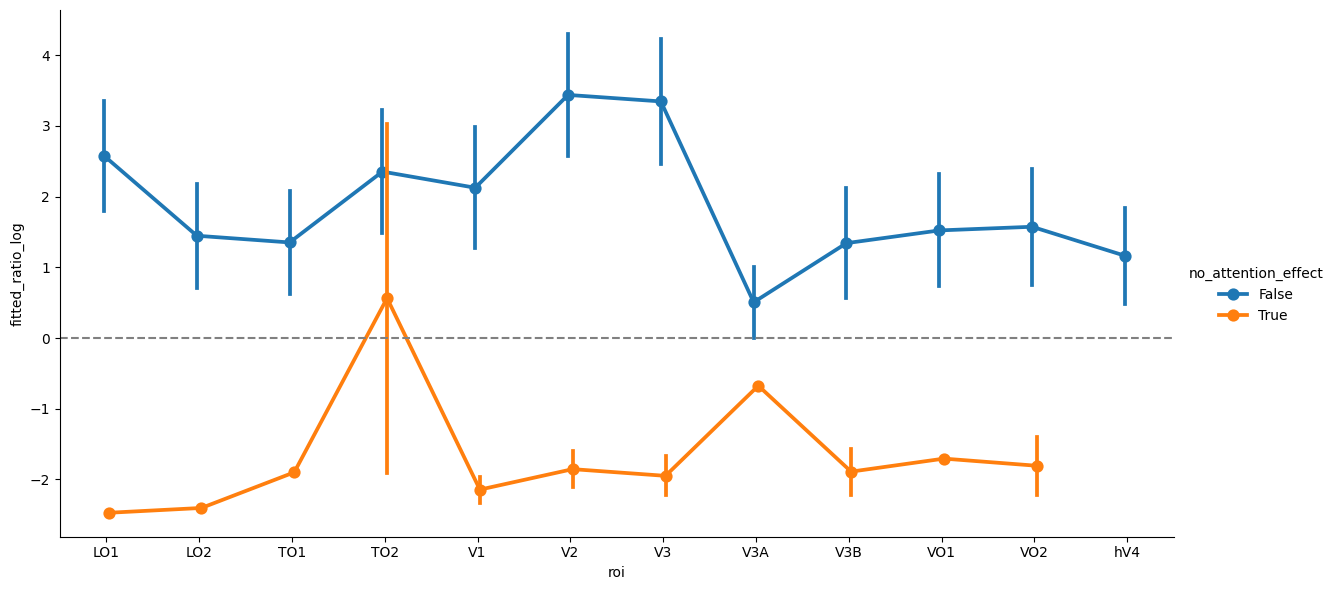

In [109]:
pars['no_attention_effect'] = pars['fitted_attention_sd'] > 40
sns.catplot(data=pars.reset_index(), x='roi', y='fitted_ratio_log', kind='swarm', height=6, aspect=2)

sns.catplot(data=pars.reset_index(), x='roi', hue='no_attention_effect', y='fitted_ratio_log', kind='point', height=6, aspect=2, errorbar='se', dodge=True)
plt.axhline(0, color='gray', linestyle='--')

In [111]:
pars.groupby('roi')['no_attention_effect'].mean()

roi
LO1    0.076923
LO2    0.076923
TO1    0.076923
TO2    0.230769
V1     0.153846
V2     0.230769
V3     0.230769
V3A    0.076923
V3B    0.153846
VO1    0.076923
VO2    0.153846
hV4    0.000000
Name: no_attention_effect, dtype: float64

In [112]:
pars['fitted_attention_sd'].groupby(['subject']).median()

subject
1     99.980710
2     17.492009
3     10.547736
4     14.716267
5     18.127997
7     16.344553
8     10.300442
9     20.382340
10    12.342736
11    10.138365
12    19.097084
13    12.054606
14    10.000000
Name: fitted_attention_sd, dtype: float64

In [113]:
def get_distractor_coords(label, radius=4.):
    mapping = {
        'upper_right': np.pi/4,
        'upper_left': 3*np.pi/4,
        'lower_left': 5*np.pi/4,
        'lower_right': 7*np.pi/4
    }
    angle = mapping.get(label, None)
    if angle is None:
        return None, None
    x = radius * np.cos(angle)
    y = radius * np.sin(angle)
    return x, y


In [114]:
def compute_net_shifts(prf_x, prf_y, prf_sd, current_condition, fixed_attention_sd, ratio):
    """Compute net shift from all 4 distractors"""
    distractor_names = ['upper_right', 'upper_left', 'lower_left', 'lower_right']
    distractor_coords = {name: get_distractor_coords(name) for name in distractor_names}
    distractor_x = np.array([coords[0] for coords in distractor_coords.values()])
    distractor_y = np.array([coords[1] for coords in distractor_coords.values()])

    net_dx, net_dy = 0.0, 0.0
    for i, (dx, dy) in enumerate(zip(distractor_x, distractor_y)):
        if distractor_names[i] == current_condition:
            current_sd = fixed_attention_sd
        else:
            current_sd = fixed_attention_sd / ratio

        dx_i = (dx - prf_x) * prf_sd**2 / (prf_sd**2 + current_sd**2)
        dy_i = (dy - prf_y) * prf_sd**2 / (prf_sd**2 + current_sd**2)
        net_dx += dx_i
        net_dy += dy_i

    # Print old distnace to the main distractor
    old_distance = np.sqrt((distractor_coords[current_condition][0] - prf_x)**2 + (distractor_coords[current_condition][1] - prf_y)**2)
    print(f"Old distance to {current_condition}: {old_distance}")
    # Print new distance to the main distractor
    new_distance = np.sqrt((distractor_coords[current_condition][0] - (prf_x + net_dx))**2 + (distractor_coords[current_condition][1] - (prf_y + net_dy))**2)
    print(f"New distance to {current_condition}: {new_distance}")
    return net_dx, net_dy

In [115]:
compute_net_shifts(2, 2, 1, 'upper_right', 10, 2)  # IGNORE

Old distance to upper_right: 1.1715728752538097
New distance to upper_right: 1.6401762735940597


(-0.3313526406534517, -0.3313526406534517)

In [116]:
attention_pars = []

for subject in range(1, 15):
    try:
        pars = pd.read_csv(f'/data/ds-retsupp/derivatives/attention_model/sub-{subject:02d}/sub-{subject:02d}_desc-attentionmodel_pars.tsv', sep='\t')
        pars['subject'] = subject
        attention_pars.append(pars)
    except FileNotFoundError:
        print(f'No attention model parameters found for subject {subject}, skipping.')

pars = pd.concat(attention_pars)

pars.set_index(['subject', 'roi', 'condition'], inplace=True)
pars

No attention model parameters found for subject 6, skipping.


x         y        sd    x_mean    y_mean  \
subject roi condition                                                       
1       LO1 upper_right  1.714145 -2.190664  0.150023  1.417563 -1.947889   
            upper_right  1.911257 -2.393614  0.299964  1.669117 -2.400257   
            upper_right -0.072275 -0.963491  1.352533  0.193999 -1.371671   
            upper_right  1.053708 -1.230834  1.227262  1.201251 -1.452247   
            upper_right  1.843598 -2.306623  0.312533  1.805177 -2.364295   
...                           ...       ...       ...       ...       ...   
14      hV4 lower_right  0.038704 -0.181220  0.402919  0.144266 -0.103065   
            lower_right -0.002099 -0.078558  0.457335 -0.201720 -0.245306   
            lower_right  0.018517 -0.044524  0.401982  0.100378 -0.320732   
            lower_right  0.003793 -0.242529  0.392757 -0.200715 -0.271634   
            lower_right -0.040015  0.090731  0.269836  0.052373 -0.180921   

                          sd_mean  voxel  empirical_dx  empirical_dy  \
subject roi condition                                                  
1       LO1 upper_right  0.917830     68      0.296582     -0.242775   
            upper_right  0.292590     74      0.242139      0.006643   
            upper_right  1.711243     82     -0.266274      0.408180   
            upper_right  1.372183     84     -0.147543      0.221414   
            upper_right  0.423883     85      0.038421      0.057672   
...                           ...    ...           ...           ...   
14      hV4 lower_right  0.250839    371     -0.105562     -0.078155   
            lower_right  0.495612    384      0.199620      0.166748   
            lower_right  0.497492    385     -0.081861      0.276208   
            lower_right  0.437470    388      0.204508      0.029105   
            lower_right  0.247802    389     -0.092388      0.271652   

                         empirical_shift  ...  predicted_dy  predicted_shift  \
subject roi condition                     ...                                  
1       LO1 upper_right         0.383276  ...      0.055985         0.058192   
            upper_right         0.242230  ...      0.006305         0.006442   
            upper_right         0.487353  ...      0.165846         0.195142   
            upper_right         0.266069  ...      0.110306         0.117556   
            upper_right         0.069298  ...      0.013123         0.013344   
...                                  ...  ...           ...              ...   
14      hV4 lower_right         0.131345  ...      0.001970         0.002842   
            lower_right         0.260102  ...      0.008691         0.010242   
            lower_right         0.288083  ...      0.009312         0.012076   
            lower_right         0.206569  ...      0.006932         0.008124   
            lower_right         0.286933  ...      0.002066         0.002760   

                         predicted_new_x  predicted_new_y  predicted_new_dist  \
subject roi condition                                                           
1       LO1 upper_right         1.433437        -1.891903            4.922146   
            upper_right         1.670440        -2.393952            5.349222   
            upper_right         0.296837        -1.205825            4.762787   
            upper_right         1.241895        -1.341942            4.461957   
            upper_right         1.807600        -2.351172            5.279236   
...                                  ...              ...                 ...   
14      hV4 lower_right         0.142218        -0.101095            3.828062   
            lower_right        -0.207140        -0.236616            3.991510   
            lower_right         0.092690        -0.311420            3.717470   
            lower_right        -0.204951        -0.264702            3.971658   
            lower_right         0.050543        -0.178855            3.838863   

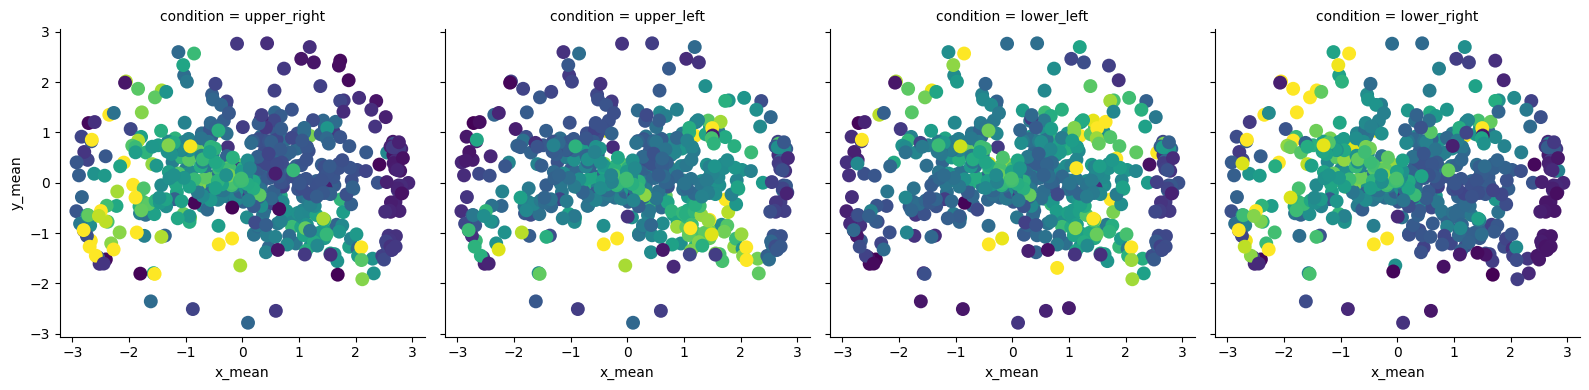

In [117]:
tmp = pars.loc[(1, 'V3')]


g = sns.FacetGrid(tmp.reset_index(), col='condition', height=4, aspect=1)
g.map_dataframe(sns.scatterplot, x='x_mean', y='y_mean', hue='predicted_shift', s=100, palette='viridis', edgecolor='none', legend=False, hue_norm=(0, .2))
# sns.scatterplot(data=tmp, x='x_mean', y='y_mean', hue='predicted_shift', s=100, palette='viridis', edgecolor='none', legend=False, hue_norm=(0, .2))

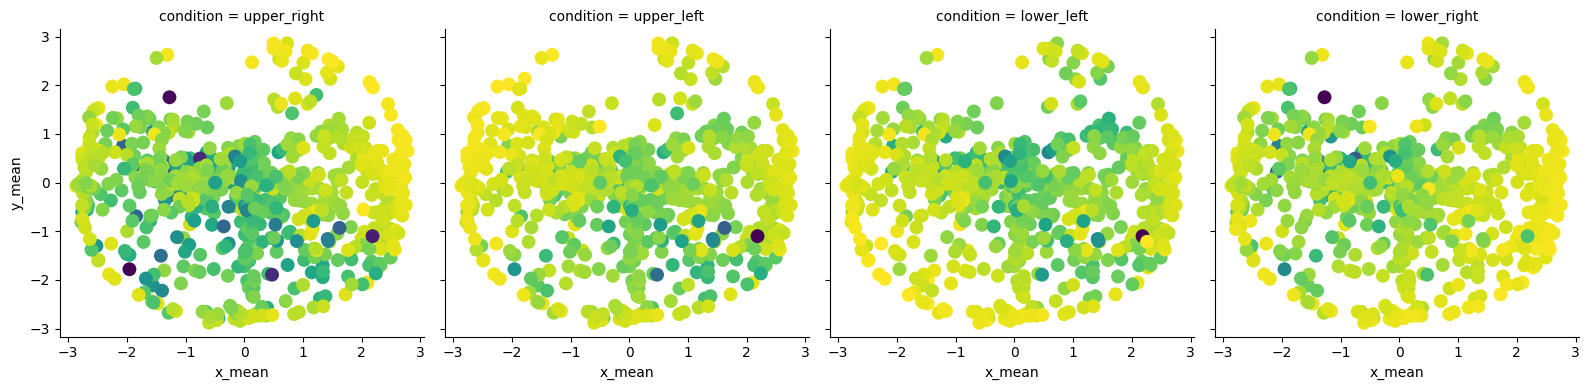

In [118]:
tmp = pars.loc[(1, 'V1')]


g = sns.FacetGrid(tmp.reset_index(), col='condition', height=4, aspect=1)
g.map_dataframe(sns.scatterplot, x='x_mean', y='y_mean', hue='predicted_shift_relative', s=100, palette='viridis', edgecolor='none', legend=False, )
# sns.scatterplot(data=tmp, x='x_mean', y='y_mean', hue='predicted_shift', s=100, palette='viridis', edgecolor='none', legend=False, hue_norm=(0, .2))

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_42725/2759553158.py:1: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=pars.xs('V1', level='roi').reset_index(), y='predicted_new_dist', x='original_dist', s=100, palette='viridis', edgecolor='none', legend=True, alpha=0.1)


(0.0, 6.0)

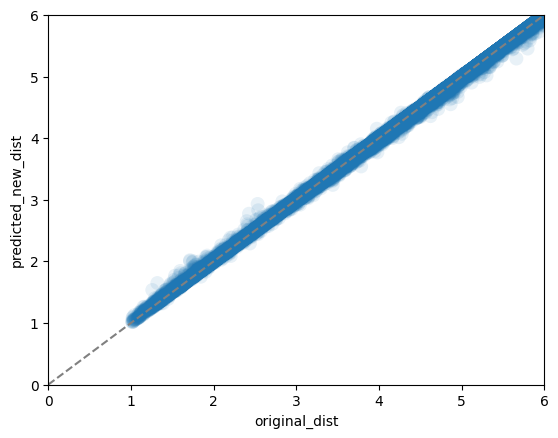

In [119]:
sns.scatterplot(data=pars.xs('V1', level='roi').reset_index(), y='predicted_new_dist', x='original_dist', s=100, palette='viridis', edgecolor='none', legend=True, alpha=0.1)
plt.axline((0, 0), slope=1, color='gray', linestyle='--')
plt.xlim(0, 6)
plt.ylim(0, 6)

In [120]:
pars['log_ratio'] = np.log(pars['ratio'])

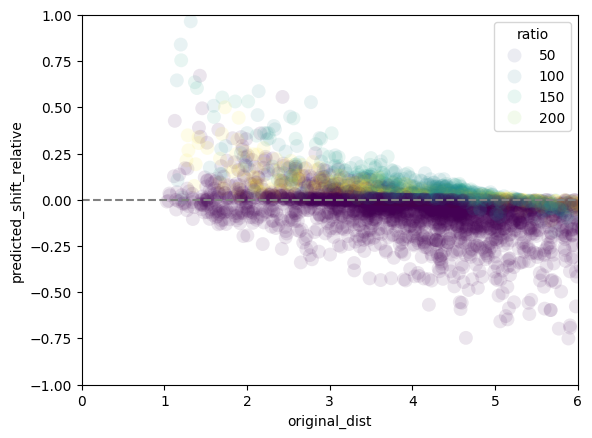

In [121]:
# pars['ratio'] = np.exp(pars['fitted_ratio_log'])

sns.scatterplot(data=pars.xs('VO1', level='roi').reset_index(), y='predicted_shift_relative', x='original_dist', s=100, palette='viridis', edgecolor='none', legend=True, alpha=0.1, hue='ratio')
# plt.axline((0, 0), slope=1, color='gray', linestyle='--')
plt.xlim(0, 6)
plt.ylim(-1, 1)
plt.axhline(0, color='gray', linestyle='--')

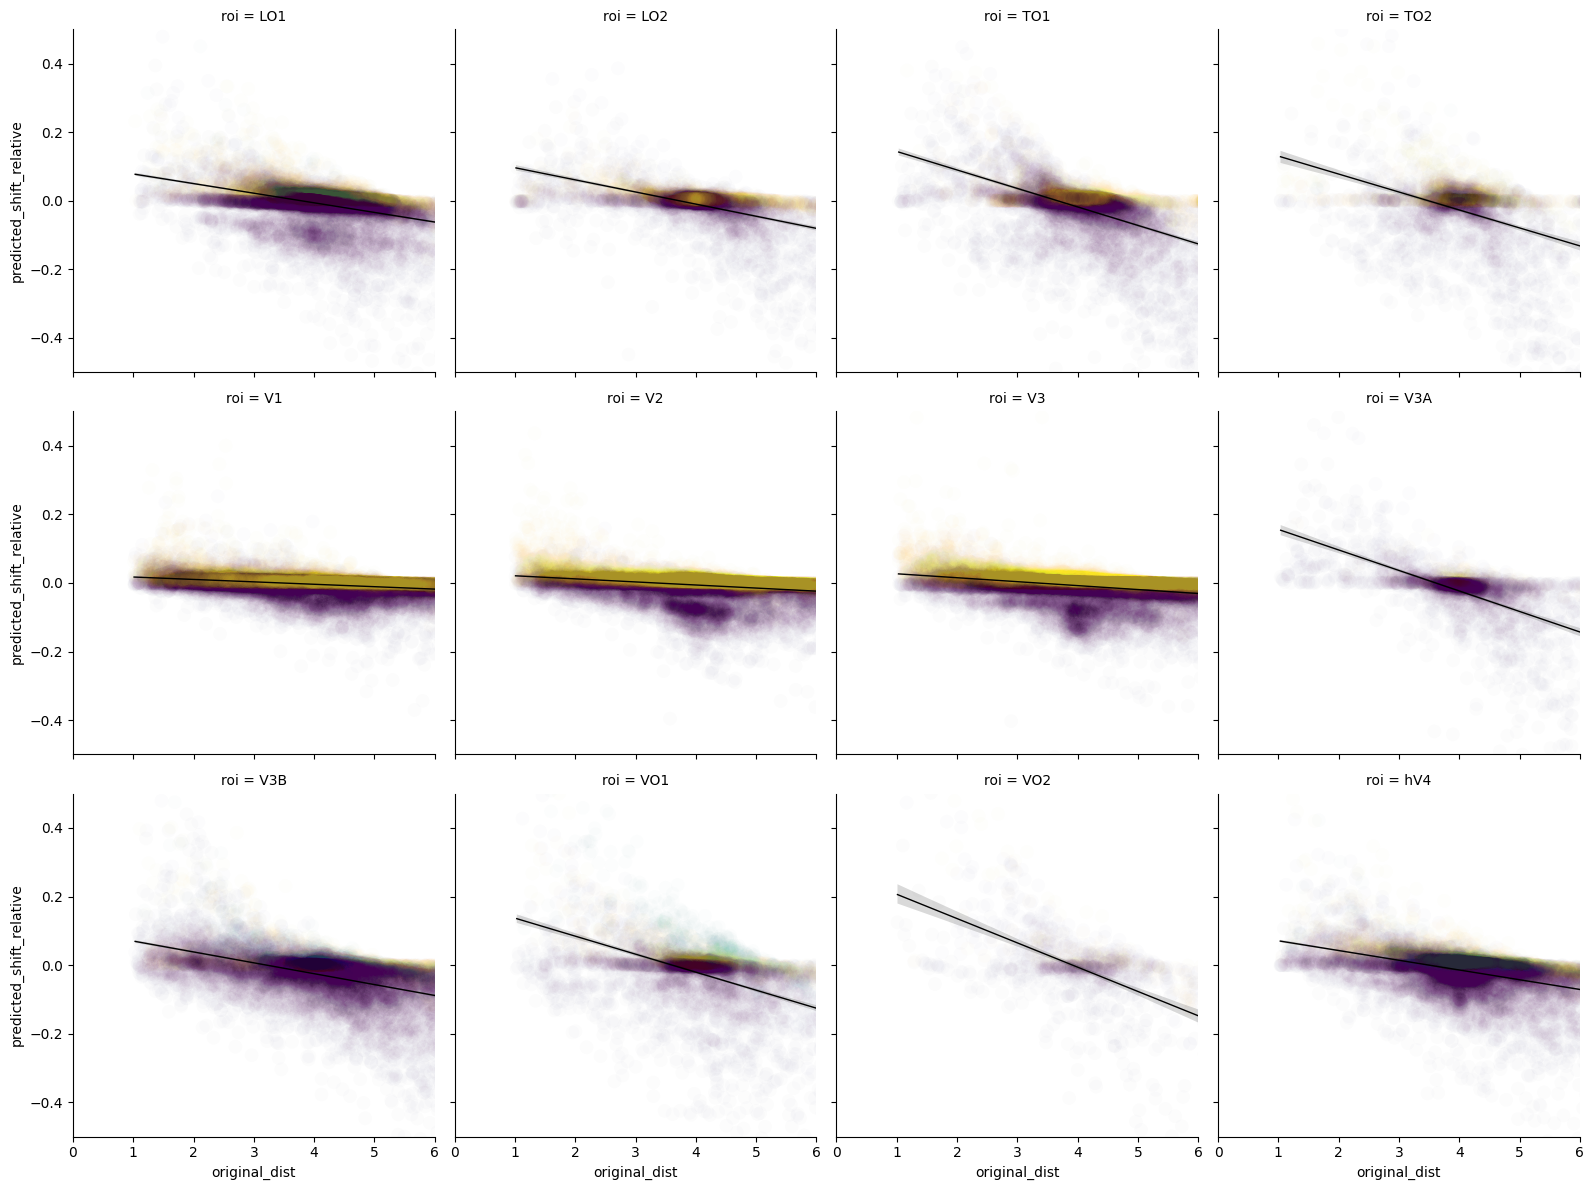

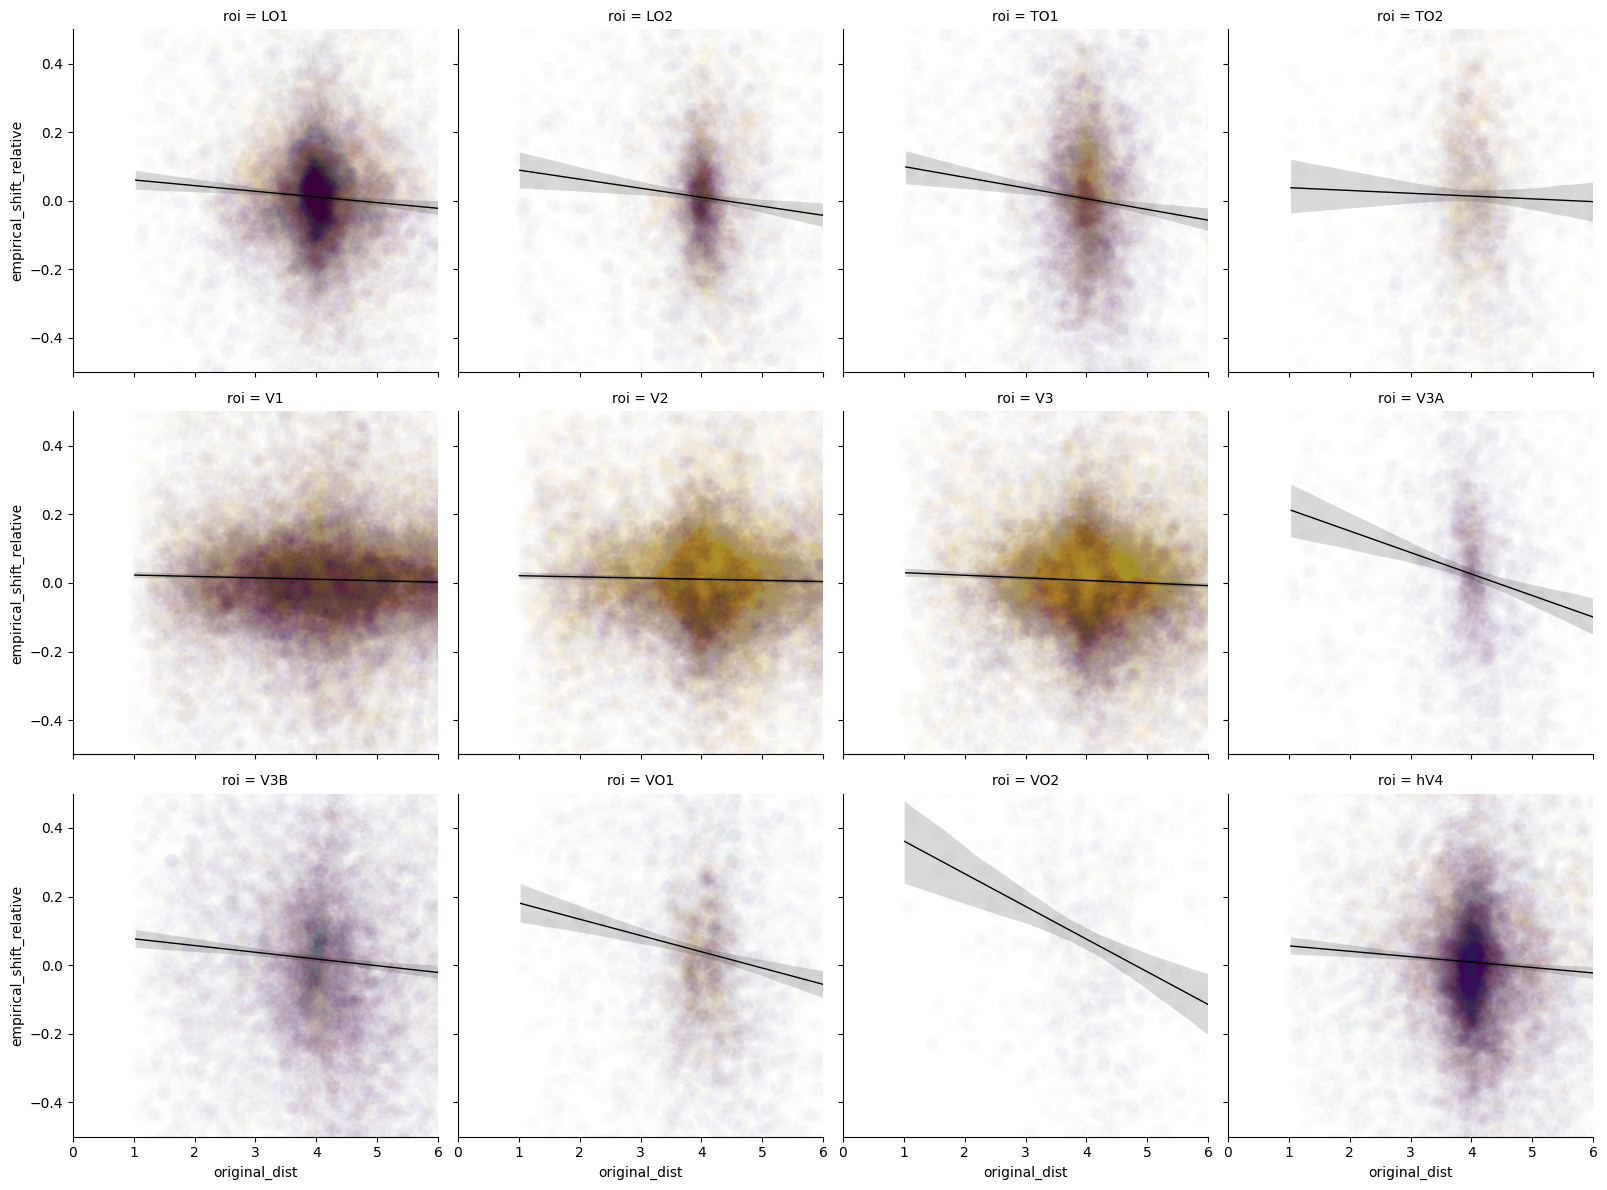

In [122]:
# pars['ratio'] = np.exp(pars['fitted_ratio_log'])

# pars['predicted_shift_relative'] = pars['predicted_shift'] / pars['original_dist']
g = sns.FacetGrid(pars.reset_index(), col='roi', col_wrap=4, height=4, aspect=1)

g.map_dataframe(sns.scatterplot, x='original_dist', y='predicted_shift_relative', s=100, palette='viridis', edgecolor='none', legend=False, alpha=0.01, hue='ratio')
g.map_dataframe(sns.regplot, x='original_dist', y='predicted_shift_relative', scatter=False, color='black', line_kws={'linewidth':1})
g.set(xlim=(0, 6), ylim=(-.5, .5))

g = sns.FacetGrid(pars.reset_index(), col='roi', col_wrap=4, height=4, aspect=1)

g.map_dataframe(sns.scatterplot, x='original_dist', y='empirical_shift_relative', s=100, palette='viridis', edgecolor='none', legend=False, alpha=0.01, hue='ratio')
g.map_dataframe(sns.regplot, x='original_dist', y='empirical_shift_relative', scatter=False, color='black', line_kws={'linewidth':1})
g.set(xlim=(0, 6), ylim=(-.5, .5))


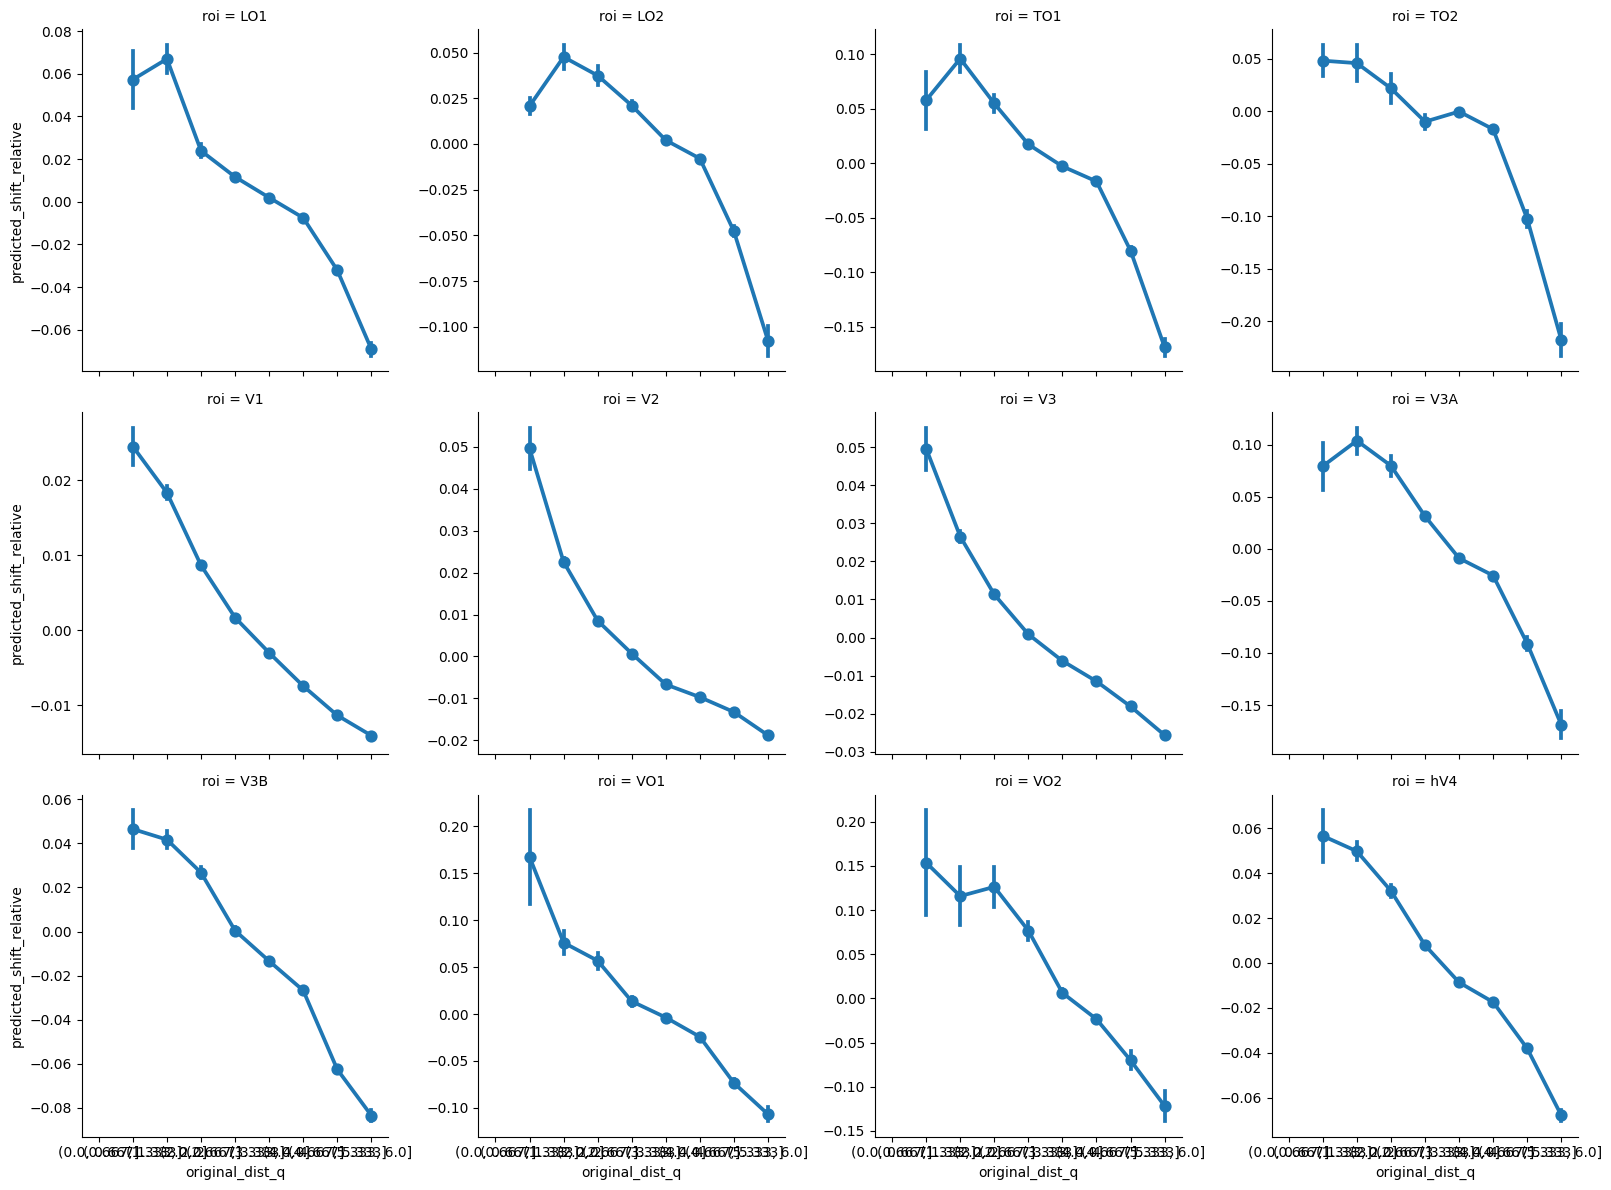

In [136]:
pars['original_dist_q'] = pd.cut(pars['original_dist'], bins=np.linspace(0, 6, 10))


sns.catplot(x='original_dist_q', y='predicted_shift_relative', data=pars.reset_index(), col='roi', col_wrap=4, height=4, aspect=1, kind='point', errorbar='se', sharey=False)

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_42725/537306796.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tmp = pars.groupby(['roi', 'original_dist_q', 'subject', 'condition'])[['predicted_shift_relative', 'empirical_shift_relative']].mean().reset_index()


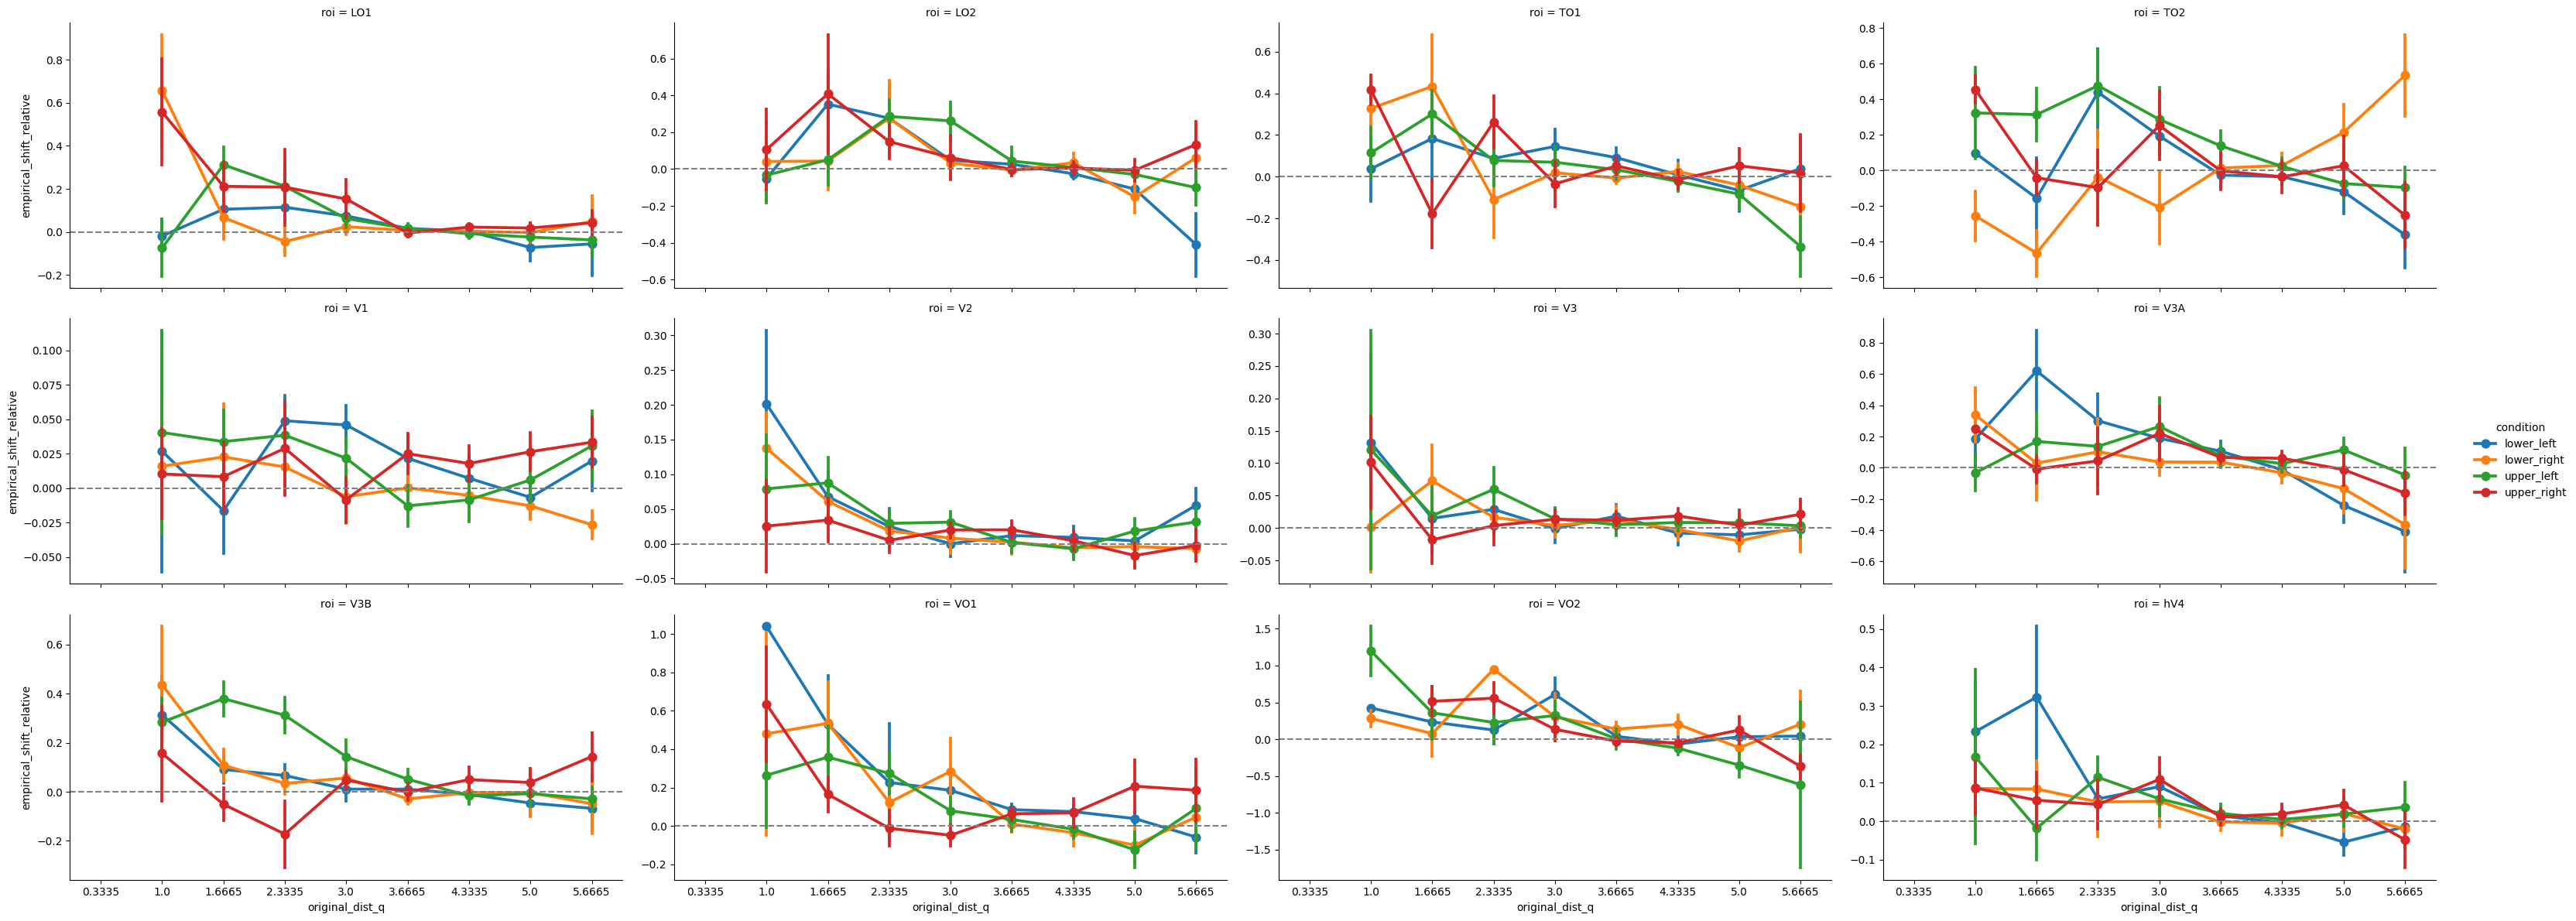

In [134]:
pars['original_dist_q'] = pd.cut(pars['original_dist'], bins=np.linspace(0, 6, 10)).apply(lambda x: x.mid)

tmp = pars.groupby(['roi', 'original_dist_q', 'subject', 'condition'])[['predicted_shift_relative', 'empirical_shift_relative']].mean().reset_index()
g = sns.catplot(x='original_dist_q', y='empirical_shift_relative', data=tmp, col='roi', col_wrap=4, height=4, aspect=2, kind='point', errorbar='se', sharey=False, hue='condition')

g.map(plt.axhline, y=0, color='gray', linestyle='--')


/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_42725/2039792487.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tmp = pars.groupby(['roi', 'original_dist_q', 'subject'])[['predicted_shift_relative', 'empirical_shift_relative']].mean().reset_index()


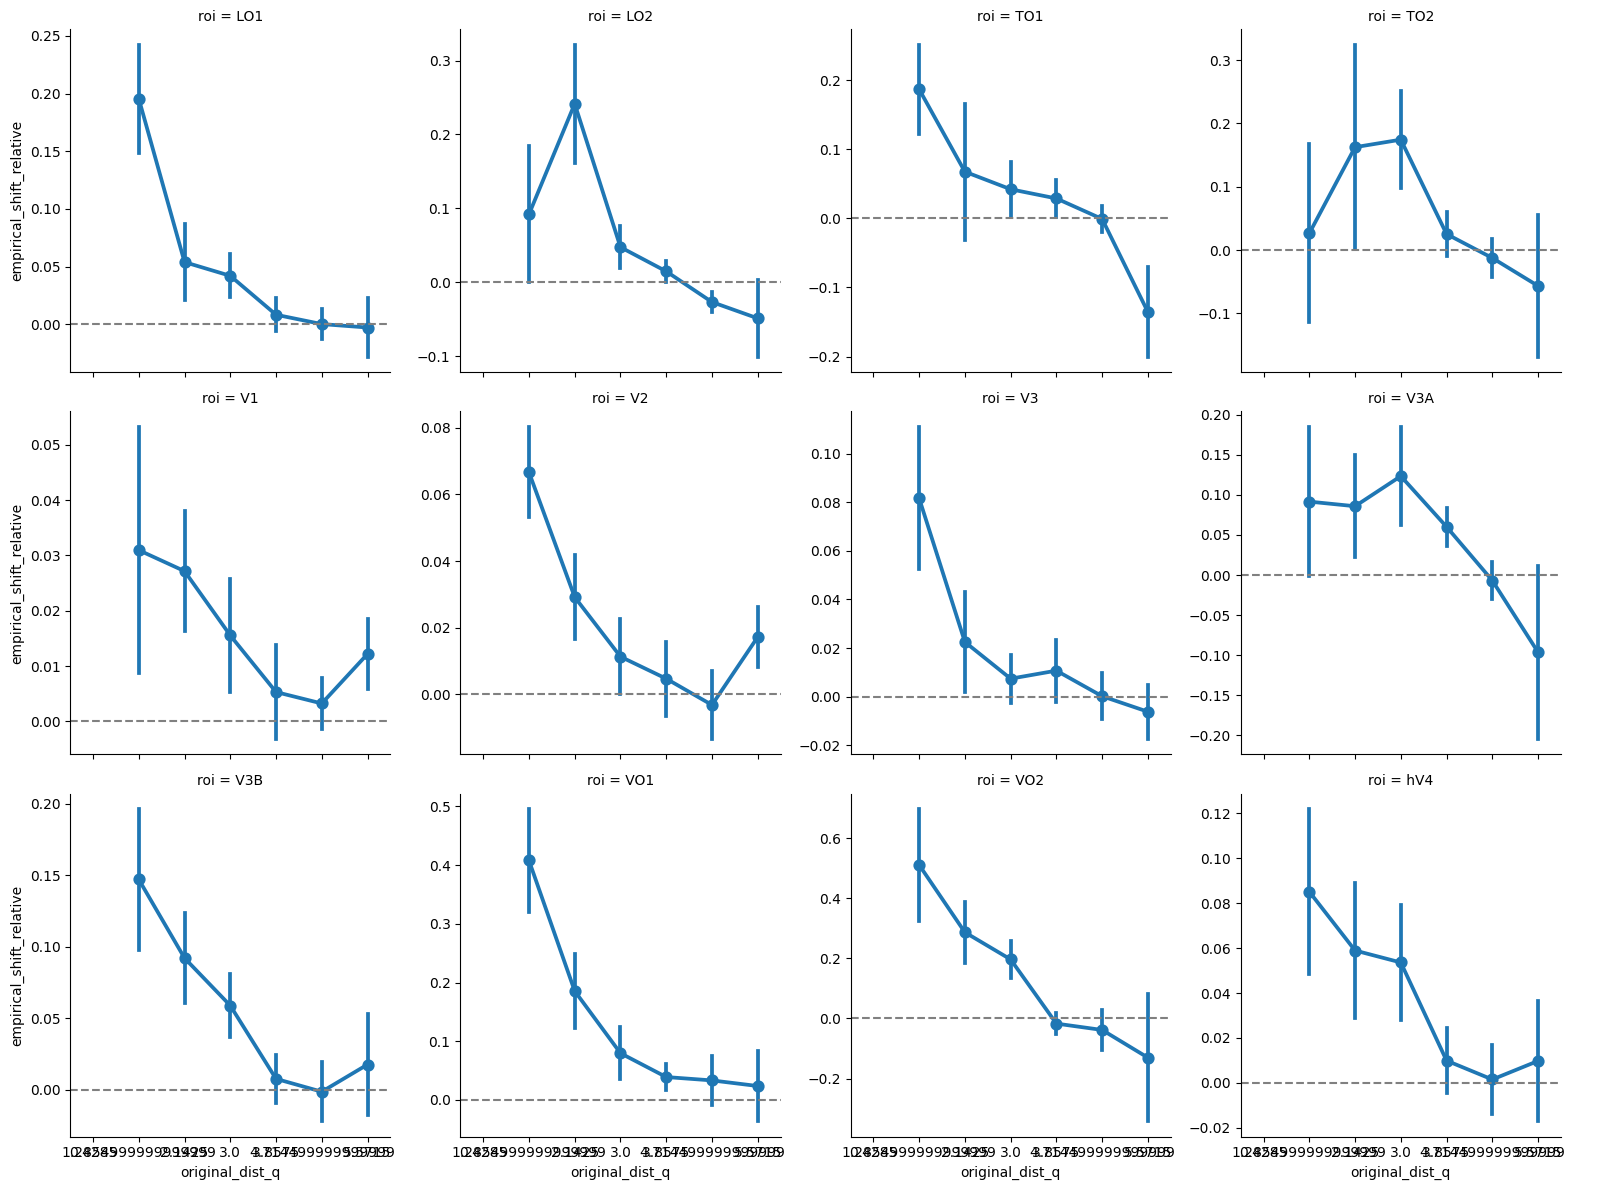

In [160]:
pars['original_dist_q'] = pd.cut(pars['original_dist'], bins=np.linspace(0, 6, 8)).apply(lambda x: x.mid)

tmp = pars.groupby(['roi', 'original_dist_q', 'subject'])[['predicted_shift_relative', 'empirical_shift_relative']].mean().reset_index()
g = sns.catplot(x='original_dist_q', y='empirical_shift_relative', data=tmp, col='roi', col_wrap=4, height=4, aspect=1, kind='point', errorbar='se', sharey=False)

g.map(plt.axhline, y=0, color='gray', linestyle='--')


/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_42725/866770181.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tmp = pars.groupby(['roi', 'original_dist_q', 'subject'])[['empirical_shift_relative_in_sd', 'empirical_shift_relative']].mean().reset_index()


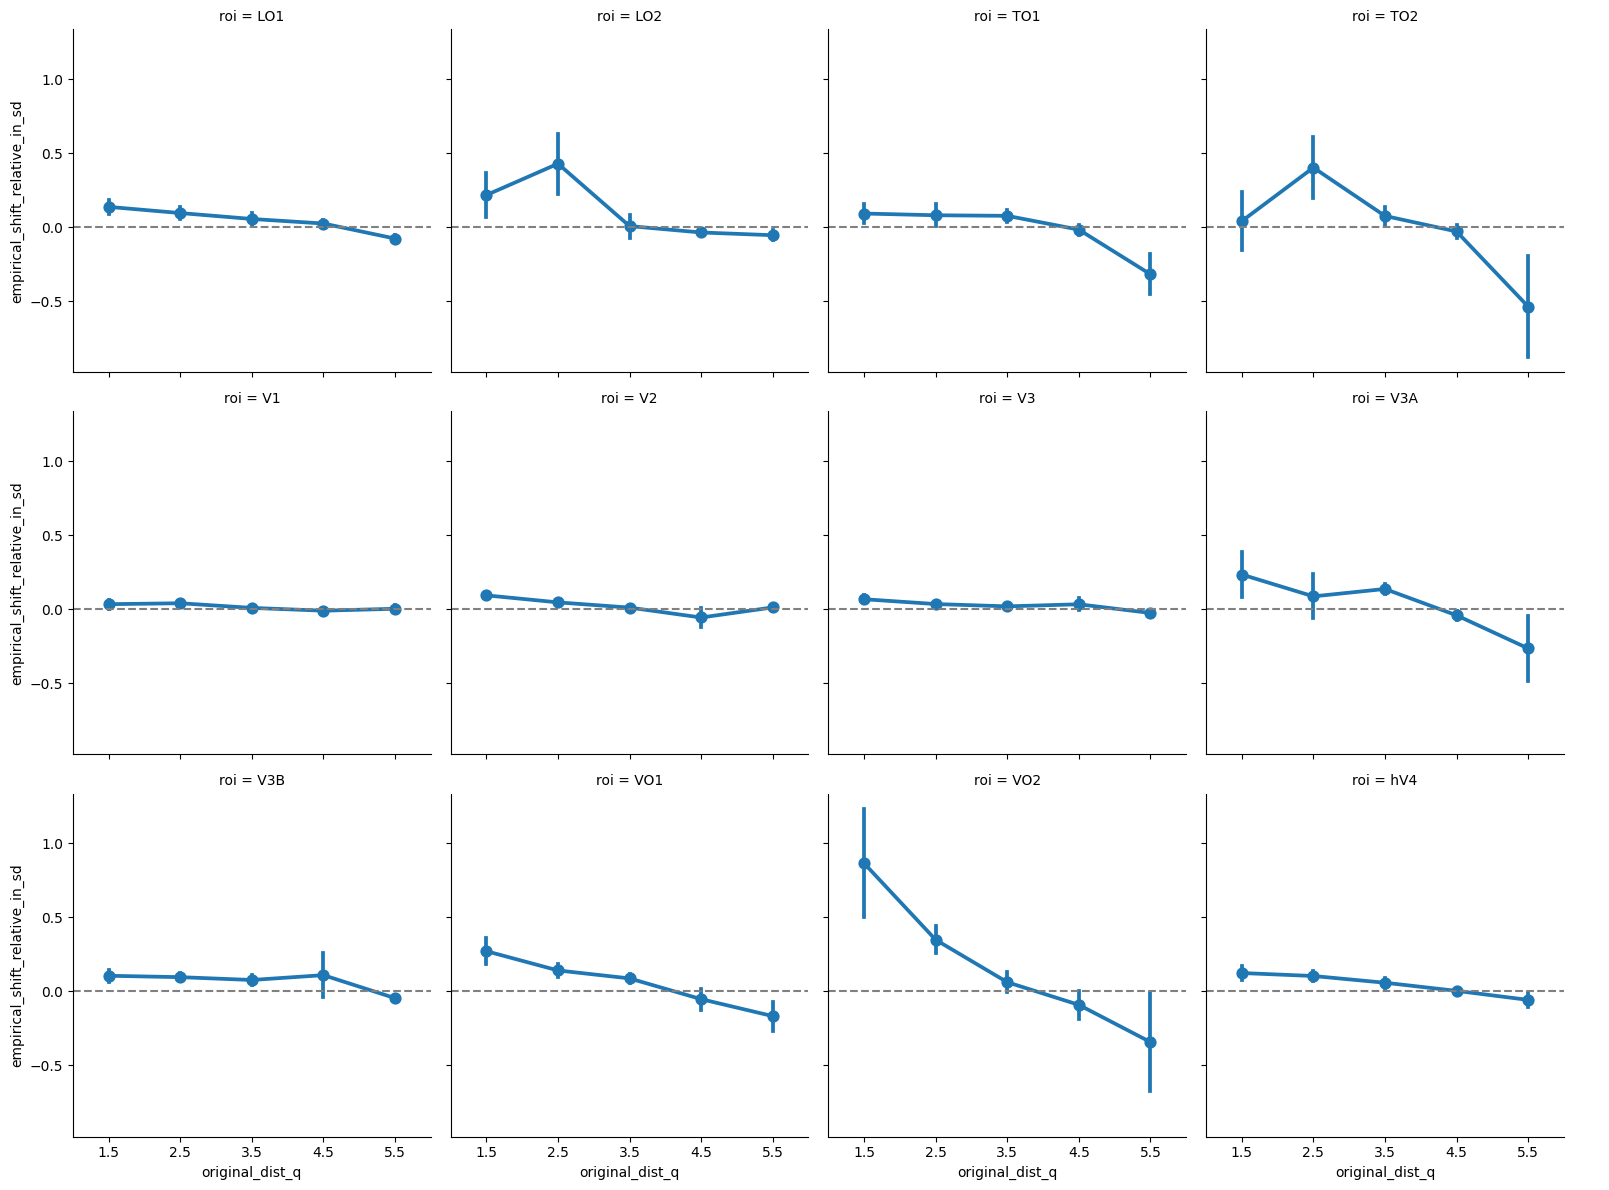

In [162]:

tmp = pars.groupby(['roi', 'original_dist_q', 'subject'])[['empirical_shift_relative_in_sd', 'empirical_shift_relative']].mean().reset_index()

g = sns.catplot(x='original_dist_q', y='empirical_shift_relative_in_sd', data=tmp, col='roi', col_wrap=4, height=4, aspect=1, kind='point', errorbar='se', sharey=True)

g.map(plt.axhline, y=0, color='gray', linestyle='--')
# g.set(ylim=(-.2, .3))